In [1]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
#import mplcyberpunk

#plt.style.use("cyberpunk")

/tmp/ipykernel_53484/1468477758.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
run = 'lr2e-06_cl32_cscscscscscscsss_NEE_lhid256_iemb64_nf10_causal_aux-0.0_drop0.3_ws_v3_MILA'

DATA_DIR = Path(os.path.join('data', 'processed', 'v3'))
RUN_DIR = Path('runs') / Path(run)
with open(RUN_DIR / Path('train_sites.txt'), 'r') as f:
    TRAIN_SITES = f.read().split('\n')
with open(RUN_DIR / Path('val_sites.txt'), 'r') as f:
    VAL_SITES = f.read().split('\n')
print({site: i for i, site in enumerate(VAL_SITES)})

{'FR-LGt': 0, 'GL-NuF': 1, 'GL-ZaF': 2, 'RU-Che': 3, 'IE-Cra': 4, 'UK-AMo': 5, 'SE-Sto': 6, 'DK-Skj': 7, 'AU-RDF': 8, 'ES-Cnd': 9, 'IT-Cp2': 10, 'MY-PSO': 11, 'NL-Loo': 12, 'RU-Fy2': 13, 'RU-Fyo': 14, 'CZ-RAJ': 15, 'DE-RuW': 16, 'FI-Ken': 17, 'FI-Var': 18, 'FR-Bil': 19, 'FR-FBn': 20, 'IL-Yat': 21, 'SE-Htm': 22, 'SE-Nor': 23, 'SE-Ros': 24, 'DE-Msr': 25, 'DK-Gds': 26, 'JP-MBF': 27, 'PA-SPn': 28, 'CZ-Lnz': 29, 'CZ-Stn': 30, 'DE-Hzd': 31, 'FR-Hes': 32, 'IT-BFt': 33, 'BE-Lcr': 34, 'FR-Gri': 35, 'IT-BCi': 36, 'IT-CA2': 37, 'CZ-KrP': 38, 'FI-Qvd': 39, 'FR-Aur': 40, 'FR-Lam': 41, 'DK-Vng': 42, 'FR-EM2': 43, 'DE-Har': 44, 'CD-Ygb': 45, 'DK-Eng': 46, 'GL-ZaH': 47, 'IT-MBo': 48, 'IT-Tor': 49, 'NL-Hor': 50, 'PA-SPs': 51, 'RU-Ha1': 52, 'SE-Deg': 53, 'BE-Dor': 54, 'FR-Tou': 55, 'IT-Niv': 56, 'FR-Mej': 57, 'ES-LgS': 58, 'ES-Ln2': 59, 'ES-Agu': 60, 'GL-Dsk': 61, 'IT-Lsn': 62, 'BE-Maa': 63, 'ES-LM1': 64, 'ES-LM2': 65}


In [3]:
site_type_distribution = pd.read_csv(os.path.join(RUN_DIR, 'site_type_distribution.csv'))
site_meta = pd.read_csv('processed_site_meta.csv')
xgb_inference_df = pd.read_csv(os.path.join(RUN_DIR, 'xgb_inference.csv'))
xgb_inference_df['timestamp'] = pd.to_datetime(xgb_inference_df['timestamp'])
deep_inference_df = pd.read_csv(os.path.join(RUN_DIR, 'deep_inference.csv'))
inference_df = xgb_inference_df
inference_df['Deep Model'] = deep_inference_df['Deep Model']

In [12]:
def compare_outputs(site, num_days):
    sub_df = inference_df[inference_df['SITE_ID'] == site]
    num_samples = len(sub_df)
    start = np.random.randint(0, num_samples - num_days*24)
    sub_df = sub_df[start:start+num_days*24]
    print(f"XGBoost RMSE:\t\t{((sub_df['NEE_VUT_REF'] - sub_df['XGBoost']) ** 2).mean() ** 0.5}")
    print(f"Deep Model RMSE:\t{((sub_df['NEE_VUT_REF'] - sub_df['Deep Model']) ** 2).mean() ** 0.5}")
    ax = sub_df[['XGBoost', 'Deep Model', 'NEE_VUT_REF']].plot(kind='line', linewidth=1, title=f"{site}: {sub_df.iloc[0]['timestamp']} - {sub_df.iloc[-1]['timestamp']}", figsize=(12,6))

    legend_1 = ax.legend(frameon=True, loc='upper left', bbox_to_anchor=(0.85,1.09), ncol=1)
    frame_1 = legend_1.get_frame()
    frame_1.set_edgecolor('white')
    frame_1.set_boxstyle('Round, pad=0.5, rounding_size=1')
    #mplcyberpunk.make_lines_glow(n_glow_lines=3)

In [5]:
def nse(targets, preds):
    return 1-(np.sum((targets-preds)**2)/np.sum((targets-np.mean(targets))**2))

def rmse(targets, preds):
    return (np.sum((targets-preds)**2)/len(targets)) ** 0.5

site_igbp_map = {}
for site in VAL_SITES:
    site_igbp = site_meta[site_meta['SITE_ID'] == site]['IGBP'].values[0]
    if site_igbp in site_igbp_map:
        site_igbp_map[site_igbp].append(site)
    else:
        site_igbp_map[site_igbp] = [site]

igbp_dfs = {}
for igbp, sites in site_igbp_map.items():
    df = inference_df[inference_df['SITE_ID'].isin(sites)]
    igbp_dfs[igbp] = df

nse_stats = {}
rmse_stats = {}
for igbp, df in igbp_dfs.items():
    nse_xgb = nse(df['NEE_VUT_REF'], df['XGBoost'])
    nse_deep = nse(df['NEE_VUT_REF'], df['Deep Model'])
    rmse_xgb = rmse(df['NEE_VUT_REF'], df['XGBoost'])
    rmse_deep = rmse(df['NEE_VUT_REF'], df['Deep Model'])

    nse_stats[igbp] = [nse_xgb, nse_deep]
    rmse_stats[igbp] = [rmse_xgb, rmse_deep]

In [6]:
def nse_rmse_graphs():
    # Creating the bar chart
    _, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

    def create_bars(ax, data, title, metric):
        labels = list(data.keys())
        values1 = [values[0] for values in data.values()]
        values2 = [values[1] for values in data.values()]
        x = range(len(labels))
        width = 0.35
        x1 = [pos - width/2 for pos in x]
        x2 = [pos + width/2 for pos in x]
        b1 = ax.bar(x1, values1, width, label='XGBoost')
        b2 = ax.bar(x2, values2, width, label='Deep Model')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, fontsize=12)
        ax.set_xlabel('IGBP Classification', fontsize=16)
        ax.set_ylabel(metric, fontsize=16)
        ax.set_title(title, fontsize=18)
        #mplcyberpunk.add_bar_gradient(bars=b1, ax=ax)
        #mplcyberpunk.add_bar_gradient(bars=b2, ax=ax)

    create_bars(ax1, nse_stats, 'NSE By Site Type (Higher is Better)', 'NSE',)
    create_bars(ax2, rmse_stats, 'RMSE By Site Type (Lower is Better)', 'RMSE')
    # Adjust subplot margins to give more space at the top
    plt.subplots_adjust(top=0.6)

    # Adding a legend with a border
    legend_1 = ax2.legend(frameon=True, loc='upper left', bbox_to_anchor=(0.75, 0.9), ncol=1)
    frame_1 = legend_1.get_frame()
    frame_1.set_edgecolor('white')
    frame_1.set_boxstyle('Round, pad=0.5, rounding_size=1')


    # Show the plot
    plt.show()

In [18]:
def train_val_split_graph():
    dist_dict = site_type_distribution.rename(columns={'Unnamed: 0': 'IGBP'}).set_index('IGBP').to_dict(orient='index')
    dist_dict_normalized = {}
    for k in dist_dict.keys():
        arr = []
        arr.append(dist_dict[k]['train'])
        arr.append(dist_dict[k]['val'])
        dist_dict[k] = arr
        arr = [a/sum(arr) for a in arr]
        dist_dict_normalized[k] = arr

    # Extracting labels and values
    labels = list(dist_dict_normalized.keys())
    values1 = [values[0] for values in dist_dict.values()]
    values2 = [values[1] for values in dist_dict.values()]
    values1_n = [values[0] for values in dist_dict_normalized.values()]
    values2_n = [values[1] for values in dist_dict_normalized.values()]

    # Plot positions
    y = range(len(labels))

    # Creating the plot
    fig, ax = plt.subplots(figsize=(12,8))
    bars1 = ax.barh(y, values1_n, label='Train', align='center', color='C4')
    bars2 = ax.barh(y, values2_n, left=values1_n, label='Val', align='center', color='C2')

    # Adding text inside the bars
    for bar, value, value_n in zip(bars1, values1, values1_n):
        ax.text(bar.get_width() / 2 + bar.get_x(), bar.get_y() + bar.get_height() / 2, f'{value}',
                va='center', ha='center', color='white', fontsize=10)

    for bar, value, prev_value_n in zip(bars2, values2, values1_n):
        if value > 0:  # Only display if the value is not zero
            ax.text(bar.get_width() / 2 + prev_value_n, bar.get_y() + bar.get_height() / 2, f'{value}',
                    va='center', ha='center', color='white', fontsize=10)

    # Labeling and aesthetics
    #mplcyberpunk.add_bar_gradient(bars=bars1, horizontal=True)
    #mplcyberpunk.add_bar_gradient(bars=bars2, horizontal=True)
    ax.set_ylabel('IGBP Classification', fontsize=18)
    ax.set_xlabel('Distribution', fontsize=16)
    ax.set_title('Train / Val Site Prevalence by IGBP', fontsize=20)
    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=14)

    # Adding a legend with a border
    plt.subplots_adjust(top=1.1)
    legend_1 = ax.legend(frameon=True, loc='upper left', bbox_to_anchor=(0.85,1.09), ncol=2)
    frame_1 = legend_1.get_frame()
    frame_1.set_edgecolor('white')
    frame_1.set_boxstyle('Round, pad=0.5, rounding_size=1')

    # Display the plot
    plt.tight_layout()
    plt.show()

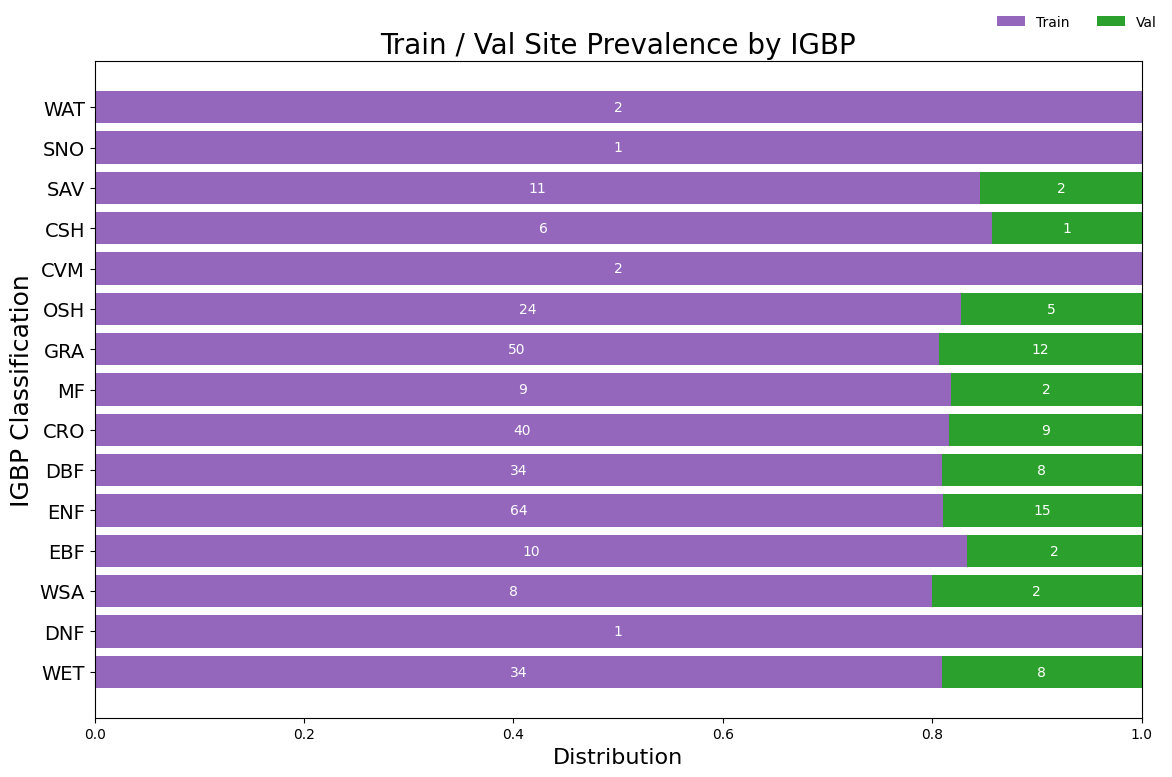

In [19]:
train_val_split_graph()

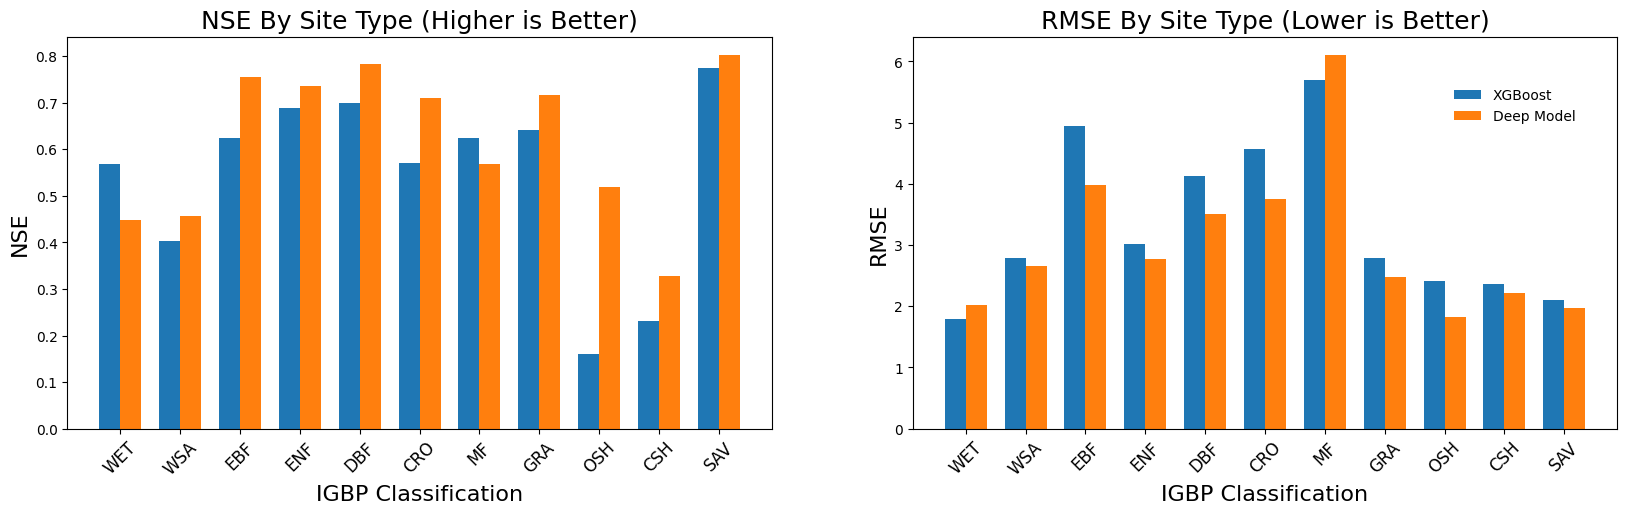

In [9]:
nse_rmse_graphs()

In [10]:
site_igbp_map

{'WET': ['FR-LGt',
  'GL-NuF',
  'GL-ZaF',
  'RU-Che',
  'IE-Cra',
  'UK-AMo',
  'SE-Sto',
  'DK-Skj'],
 'WSA': ['AU-RDF', 'ES-Cnd'],
 'EBF': ['IT-Cp2', 'MY-PSO'],
 'ENF': ['NL-Loo',
  'RU-Fy2',
  'RU-Fyo',
  'CZ-RAJ',
  'DE-RuW',
  'FI-Ken',
  'FI-Var',
  'FR-Bil',
  'FR-FBn',
  'IL-Yat',
  'SE-Htm',
  'SE-Nor',
  'SE-Ros',
  'DE-Msr',
  'DK-Gds'],
 'DBF': ['JP-MBF',
  'PA-SPn',
  'CZ-Lnz',
  'CZ-Stn',
  'DE-Hzd',
  'FR-Hes',
  'IT-BFt',
  'BE-Lcr'],
 'CRO': ['FR-Gri',
  'IT-BCi',
  'IT-CA2',
  'CZ-KrP',
  'FI-Qvd',
  'FR-Aur',
  'FR-Lam',
  'DK-Vng',
  'FR-EM2'],
 'MF': ['DE-Har', 'CD-Ygb'],
 'GRA': ['DK-Eng',
  'GL-ZaH',
  'IT-MBo',
  'IT-Tor',
  'NL-Hor',
  'PA-SPs',
  'RU-Ha1',
  'SE-Deg',
  'BE-Dor',
  'FR-Tou',
  'IT-Niv',
  'FR-Mej'],
 'OSH': ['ES-LgS', 'ES-Ln2', 'ES-Agu', 'GL-Dsk', 'IT-Lsn'],
 'CSH': ['BE-Maa'],
 'SAV': ['ES-LM1', 'ES-LM2']}

XGBoost RMSE:		1.8935035299968745
Deep Model RMSE:	1.1242360483166185


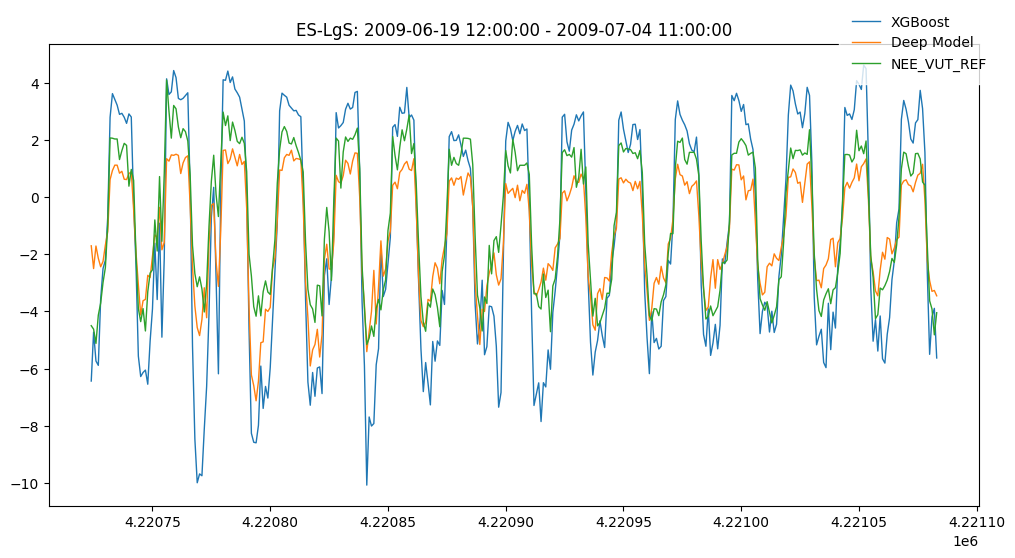

In [15]:
compare_outputs('ES-LgS', 15)

In [ ]:
print('XGBoost')
print('  Total NSE: ', nse(inference_df['NEE_VUT_REF'], inference_df['XGBoost']))
print('  Total RMSE: ', rmse(inference_df['NEE_VUT_REF'], inference_df['XGBoost']))
print()
print('Deep Model')
print('  Total NSE: ', nse(inference_df['NEE_VUT_REF'], inference_df['Deep Model']))
print('  Total RMSE: ', rmse(inference_df['NEE_VUT_REF'], inference_df['Deep Model']))

XGBoost
  Total NSE:  0.6373641379539328
  Total RMSE:  3.4284665999332358

Deep Model
  Total NSE:  0.7231594480032457
  Total RMSE:  2.995569506127106


In [ ]:
for site in list(inference_df['SITE_ID'].unique()):
    idf = inference_df[inference_df['SITE_ID'] == site]
    print(site)
    print('  XBG NSE: ', nse(idf['NEE_VUT_REF'], idf['XGBoost']))
    print('  XGB RMSE: ', rmse(idf['NEE_VUT_REF'], idf['XGBoost']))
    print()
    print('  Deep NSE: ', nse(idf['NEE_VUT_REF'], idf['Deep Model']))
    print('  Deep RMSE: ', rmse(idf['NEE_VUT_REF'], idf['Deep Model']))


FR-LGt
  XBG NSE:  0.6725631001102177
  XGB RMSE:  2.1933721491346283

  Deep NSE:  0.6499510122284663
  Deep RMSE:  2.267842698078776
GL-NuF
  XBG NSE:  0.23621684639192086
  XGB RMSE:  1.2283140722557842

  Deep NSE:  -0.19813793193099172
  Deep RMSE:  1.5384302071557852
GL-ZaF
  XBG NSE:  0.3391172888994711
  XGB RMSE:  1.3231924879343244

  Deep NSE:  -0.2864363749057377
  Deep RMSE:  1.8460989999632167
RU-Che
  XBG NSE:  0.35587382410156354
  XGB RMSE:  1.2124651918144491

  Deep NSE:  0.17559587314211123
  Deep RMSE:  1.371683403176058
IE-Cra
  XBG NSE:  0.8040364464690112
  XGB RMSE:  1.0300427057730388

  Deep NSE:  0.22146752851736295
  Deep RMSE:  2.0530803361567025
UK-AMo
  XBG NSE:  0.7278442974586364
  XGB RMSE:  1.4426858534603253

  Deep NSE:  0.002748921823294448
  Deep RMSE:  2.7616288511826377
SE-Sto
  XBG NSE:  -2.1067079939529654
  XGB RMSE:  1.2139588564462789

  Deep NSE:  -3.691106167510469
  Deep RMSE:  1.4917339757291967
DK-Skj
  XBG NSE:  0.559670653070496
  X